In [65]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from catboost import CatBoostClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e22/sample_submission.csv
/kaggle/input/playground-series-s3e22/train.csv
/kaggle/input/playground-series-s3e22/test.csv


In [4]:
test_path = '/kaggle/input/playground-series-s3e22/test.csv'
train_path = '/kaggle/input/playground-series-s3e22/train.csv'

In [5]:
test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

# **EDA**

In [6]:
train.head()

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

In [26]:
train.outcome.value_counts()

outcome
lived         574
died          410
euthanized    251
Name: count, dtype: int64

In [55]:
target = ['outcome']

**Columns with Missing Values**

In [12]:
train.isnull().sum()/len(train)

id                       0.000000
surgery                  0.000000
age                      0.000000
hospital_number          0.000000
rectal_temp              0.000000
pulse                    0.000000
respiratory_rate         0.000000
temp_of_extremities      0.031579
peripheral_pulse         0.048583
mucous_membrane          0.017004
capillary_refill_time    0.004858
pain                     0.035628
peristalsis              0.016194
abdominal_distention     0.018623
nasogastric_tube         0.064777
nasogastric_reflux       0.017004
nasogastric_reflux_ph    0.000000
rectal_exam_feces        0.153846
abdomen                  0.172470
packed_cell_volume       0.000000
total_protein            0.000000
abdomo_appearance        0.038866
abdomo_protein           0.000000
surgical_lesion          0.000000
lesion_1                 0.000000
lesion_2                 0.000000
lesion_3                 0.000000
cp_data                  0.000000
outcome                  0.000000
dtype: float64

In [20]:
def columns_with_missing_values(df, target, percentage):
    columns_and_percentage = df.isnull().sum()/len(df)
    cols = df.drop(target, axis=1).columns
    columns_with_missing = []
    for i in range(0, len(cols)):
        if columns_and_percentage[i] > percentage:
            columns_with_missing.append(cols[i])
    return columns_with_missing

In [25]:
cols_to_drop = columns_with_missing_values(train, target, 0.1)
cols_to_drop

['rectal_exam_feces', 'abdomen']

In [29]:
train.drop(cols_to_drop, axis=1, inplace=True)

In [42]:
num_cols_to_impute = columns_with_missing_values(train.select_dtypes(include='number'), 0)
num_cols_to_impute

[]

In [45]:
def imputation_with_median(df, num_cols_to_impute):
    for col in num_cols_to_impute:
        df[col].fillna(df[col].median()[0], inplace=True)

In [46]:
imputation_with_median(train, num_cols_to_impute)

In [47]:
cat_cols_to_impute = columns_with_missing_values(train.select_dtypes(exclude='number'), 0)
cat_cols_to_impute

['temp_of_extremities',
 'peripheral_pulse',
 'mucous_membrane',
 'capillary_refill_time',
 'pain',
 'peristalsis',
 'abdominal_distention',
 'nasogastric_tube',
 'nasogastric_reflux',
 'abdomo_appearance']

In [48]:
def imputation_with_none(df, cat_cols_to_impute):
    for col in cat_cols_to_impute:
        df[col].fillna('None', inplace=True)

In [49]:
imputation_with_none(train, cat_cols_to_impute)

**Filtering Columns Based on Variance**

In [51]:
train.select_dtypes(include='number').var()

id                       1.272050e+05
hospital_number          1.839829e+12
rectal_temp              6.219968e-01
pulse                    8.473128e+02
respiratory_rate         2.706705e+02
nasogastric_reflux_ph    3.753351e+00
packed_cell_volume       1.110031e+02
total_protein            7.116331e+02
abdomo_protein           2.525542e+00
lesion_1                 2.955807e+07
lesion_2                 3.752191e+04
lesion_3                 7.895914e+03
dtype: float64

In [60]:
def filtering_columns_based_on_variance(df, target, threshold):
    numeric = df.drop(target, axis=1).select_dtypes(include='number')
    num_and_var = numeric.var()
    numeric_cols = numeric.columns
    cols_witn_low_variance = []
    for i in range(0, len(numeric_cols)):
        if num_and_var[i] < threshold:   # variance threshold
            cols_witn_low_variance.append(numeric_cols[i])  
    return cols_witn_low_variance

In [61]:
cols_witn_low_variance = filtering_columns_based_on_variance(train, target, 10)
cols_witn_low_variance

['rectal_temp', 'nasogastric_reflux_ph', 'abdomo_protein']

In [62]:
train.drop(cols_witn_low_variance, axis=1, inplace=True)

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1235 non-null   object 
 7   peripheral_pulse       1235 non-null   object 
 8   mucous_membrane        1235 non-null   object 
 9   capillary_refill_time  1235 non-null   object 
 10  pain                   1235 non-null   object 
 11  peristalsis            1235 non-null   object 
 12  abdominal_distention   1235 non-null   object 
 13  nasogastric_tube       1235 non-null   object 
 14  nasogastric_reflux     1235 non-null   object 
 15  pack

**Filtering Highly Correlated Columns**

<Axes: >

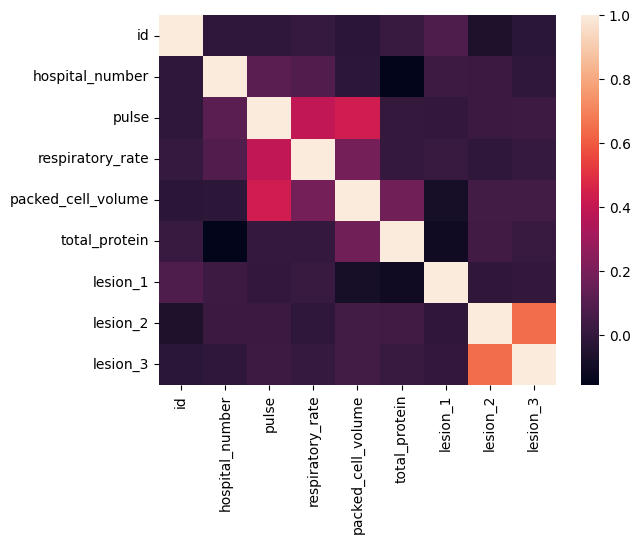

In [66]:
sns.heatmap(train.select_dtypes(include='number').corr())